Pré-traitement des données

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
import matplotlib.pyplot as plt

sensors_path = "/content/drive/MyDrive/Colab Notebooks/sensors.csv"
records_path = "/content/drive/MyDrive/Colab Notebooks/records_new.csv"

sensors = pd.read_csv(sensors_path)
records = pd.read_csv(records_path)

records['timestamp'] = pd.to_datetime(records['timestamp'], unit='s')

sensor_mapping = dict(zip(sensors['sensor_addr'], sensors['parent_addr']))
records['parent_addr'] = records['transmitter_addr'].map(sensor_mapping)

parent_usage = records.groupby(['timestamp', 'parent_addr'])['value'].sum().reset_index()
child_usage = records.groupby(['timestamp', 'transmitter_addr'])['value'].sum().reset_index()

df = pd.merge(child_usage, parent_usage, left_on=['timestamp', 'transmitter_addr'],
              right_on=['timestamp', 'parent_addr'], how='left', suffixes=('_child', '_parent'))
df.fillna(0, inplace=True)  # remplacer les vaeurs nan par 0

df['diff_usage'] = df['value_parent'] - df['value_child']

# on a pris une écart de 20% pour définir une fuite
df['fuite'] = (df['diff_usage'] > df['value_parent'] * 0.2).astype(int)

df = df.drop(columns=['parent_addr', 'value_parent'])

if df['fuite'].sum() == 0:
    df_fuite = df.sample(frac=0.05, random_state=42)  # ajout de 5% de fuites artificielles
    df_fuite['fuite'] = 1
    df_fuite['diff_usage'] = df_fuite['value_child'] * 0.5
    df = pd.concat([df, df_fuite])

print("Données prétraitées.")


Données prétraitées.


Utilisation de Gradient Boosting pour l'entrainement

In [6]:
X = df[['value_child', 'diff_usage']]
y = df['fuite']

# séparer l'entrainement et le test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# initialisation et entrainement
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train, y_train)

# prédictions
y_pred = gbc.predict(X_test)

# évaluation du modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Précision du modèle : {accuracy:.2f}")
print("Rapport de classification :\n", report)


Précision du modèle : 0.96
Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    318097
           1       1.00      0.16      0.28     15905

    accuracy                           0.96    334002
   macro avg       0.98      0.58      0.63    334002
weighted avg       0.96      0.96      0.95    334002



Visualisation des fuites détectées

<ipython-input-7-59bde6fd4c22>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['fuite'], palette="viridis")


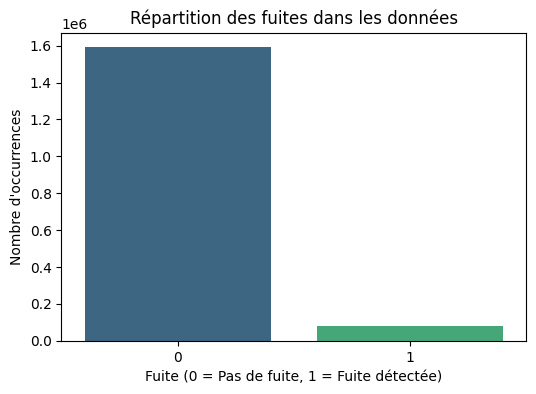

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x=df['fuite'], palette="viridis")
plt.title("Répartition des fuites dans les données")
plt.xlabel("Fuite (0 = Pas de fuite, 1 = Fuite détectée)")
plt.ylabel("Nombre d'occurrences")
plt.show()


Evaluation de la performance du modèle

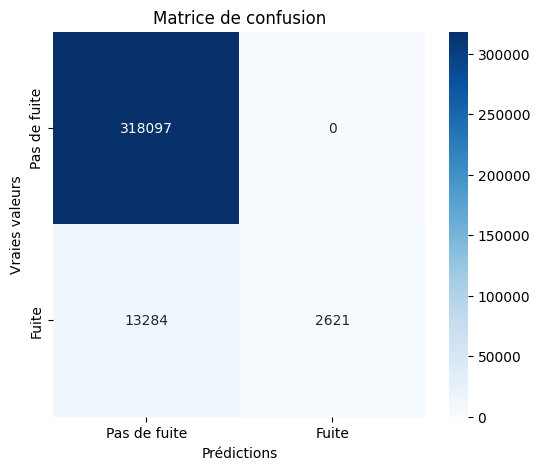

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

# calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pas de fuite", "Fuite"], yticklabels=["Pas de fuite", "Fuite"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()


affichage de toutes les fuites détectées avec leur date, heure et intensité

In [9]:
# ajouter les prédictions au DataFrame
df['prediction'] = gbc.predict(X)

# filtrer uniquement les lignes où une fuite est détectée (prediction = 1)
fuites_detectees = df[df['prediction'] == 1][['timestamp', 'transmitter_addr', 'value_child', 'diff_usage']]

# afficher les fuites détectées avec la date et l'heure
fuites_detectees.sort_values(by='timestamp', ascending=True, inplace=True)
print("Dates et heures des fuites détectées :")
print(fuites_detectees)


Dates et heures des fuites détectées :
                  timestamp  transmitter_addr  value_child  diff_usage
327155  2022-02-12 01:21:05  578f9c72ac05fa55           38        19.0
328096  2022-02-12 04:14:20  42d66883f2f7bec0           38        19.0
331047  2022-02-12 13:21:36  578f9c72ac05fa55           38        19.0
331698  2022-02-12 15:22:07  578f9c72ac05fa55           38        19.0
333672  2022-02-12 21:29:24  3d263811b5347cf1           76        38.0
...                     ...               ...          ...         ...
1590010 2022-07-24 13:05:37  e3a54e9f6e90b54f            9         4.5
1590025 2022-07-24 13:08:02  7de8b8593d784cb6            9         4.5
1590121 2022-07-24 13:28:17  00088bb4bab91174           18         9.0
1590364 2022-07-24 14:21:32  9a0a97c9082f2f8b           10         5.0
1590442 2022-07-24 14:47:13  a09c70b1ef3d7be7            7         3.5

[13118 rows x 4 columns]


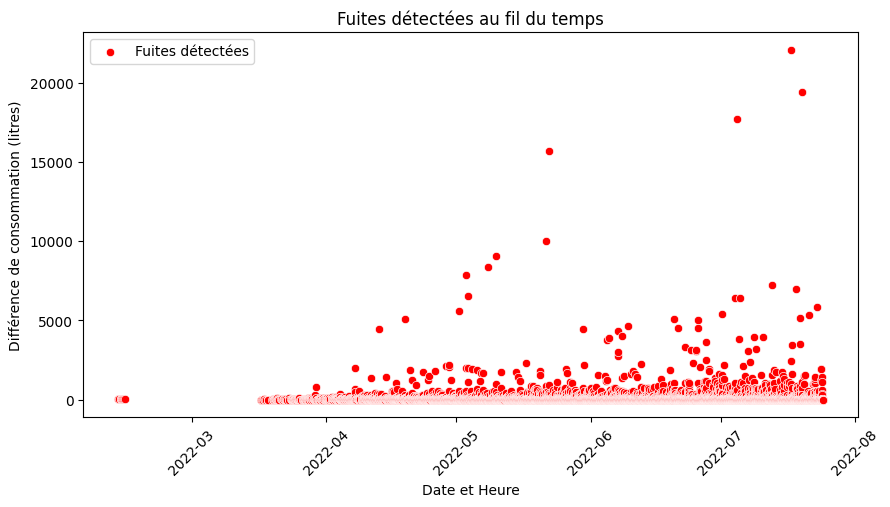

In [10]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=fuites_detectees['timestamp'], y=fuites_detectees['diff_usage'], color="red", label="Fuites détectées")
plt.xlabel("Date et Heure")
plt.ylabel("Différence de consommation (litres)")
plt.title("Fuites détectées au fil du temps")
plt.xticks(rotation=45)
plt.legend()
plt.show()


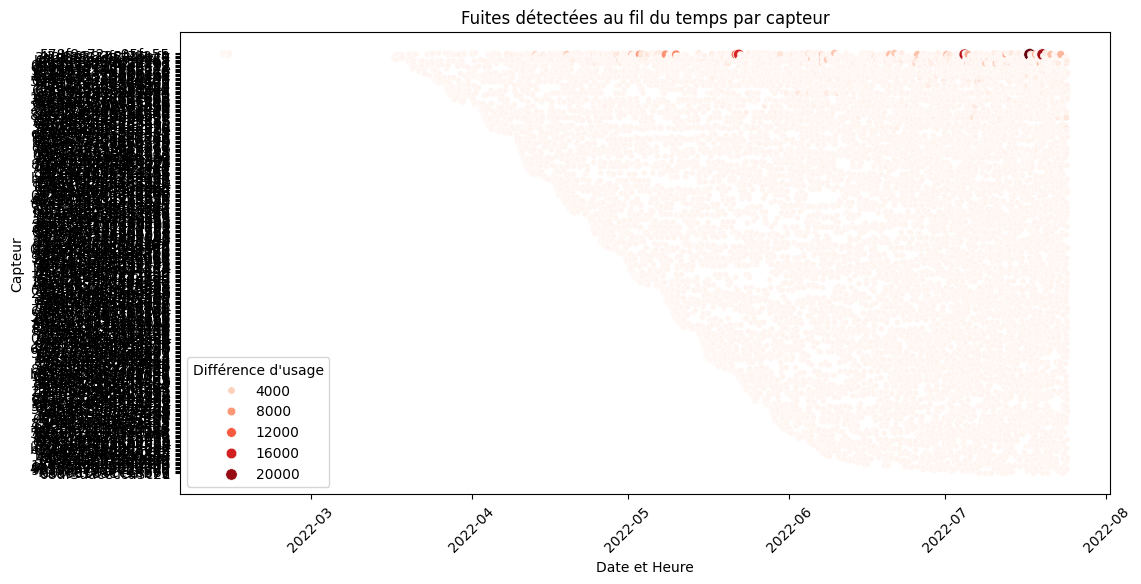

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=fuites_detectees, x='timestamp', y='transmitter_addr', size='diff_usage', hue='diff_usage', palette="Reds", legend=True)
plt.xlabel("Date et Heure")
plt.ylabel("Capteur")
plt.title("Fuites détectées au fil du temps par capteur")
plt.xticks(rotation=45)
plt.legend(title="Différence d'usage")
plt.show()


In [12]:
import pandas as pd

# Générer les prédictions
df['prediction'] = gbc.predict(X)

# Filtrer uniquement les lignes où une fuite est détectée
fuites_detectees = df[df['prediction'] == 1][['timestamp', 'transmitter_addr', 'value_child', 'diff_usage']]

# Trier par date pour une meilleure lisibilité
fuites_detectees = fuites_detectees.sort_values(by='timestamp', ascending=True)

# Afficher sous forme de tableau
print(fuites_detectees)


                  timestamp  transmitter_addr  value_child  diff_usage
327155  2022-02-12 01:21:05  578f9c72ac05fa55           38        19.0
328096  2022-02-12 04:14:20  42d66883f2f7bec0           38        19.0
331047  2022-02-12 13:21:36  578f9c72ac05fa55           38        19.0
331698  2022-02-12 15:22:07  578f9c72ac05fa55           38        19.0
333672  2022-02-12 21:29:24  3d263811b5347cf1           76        38.0
...                     ...               ...          ...         ...
1590010 2022-07-24 13:05:37  e3a54e9f6e90b54f            9         4.5
1590025 2022-07-24 13:08:02  7de8b8593d784cb6            9         4.5
1590121 2022-07-24 13:28:17  00088bb4bab91174           18         9.0
1590364 2022-07-24 14:21:32  9a0a97c9082f2f8b           10         5.0
1590442 2022-07-24 14:47:13  a09c70b1ef3d7be7            7         3.5

[13118 rows x 4 columns]


In [13]:
from IPython.display import display
display(fuites_detectees)


,timestamp,transmitter_addr,value_child,diff_usage
327155,2022-02-12 01:21:05,578f9c72ac05fa55,38,19.0
328096,2022-02-12 04:14:20,42d66883f2f7bec0,38,19.0
331047,2022-02-12 13:21:36,578f9c72ac05fa55,38,19.0
331698,2022-02-12 15:22:07,578f9c72ac05fa55,38,19.0
333672,2022-02-12 21:29:24,3d263811b5347cf1,76,38.0
...,...,...,...,...
1590010,2022-07-24 13:05:37,e3a54e9f6e90b54f,9,4.5
1590025,2022-07-24 13:08:02,7de8b8593d784cb6,9,4.5
1590121,2022-07-24 13:28:17,00088bb4bab91174,18,9.0
1590364,2022-07-24 14:21:32,9a0a97c9082f2f8b,10,5.0
